# Binary Recurrent Neural Net (RNN)
---

Now we have the concept of Stacked series, we can see what we can do with them. One thing we might do is run each timestep through a linear layer, a bit like the FeedForward but then, times the number of timesteps. That would give a big matrix output layer of size `#Nodes x #Stacked Records`. That matrix can be flattened to a single array and used in consequent layers.

Though this does give our Network the ability to see and use all the payments in the series, and it might actually give OK results, we can intuitively assume such model might look for very specific patterns at very specific timestamps, that it might not totally understand there is a sequence/order to these payments and might not really generalize the way we hope.

So this is probably not what we want to do;

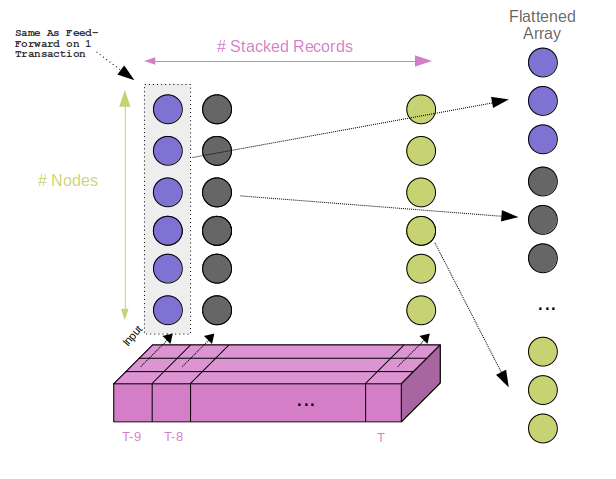


`RNN's (Recurrent Neural Net)` are a specific architecture where the RNN Layer 'unfolds' a dimension, in our case the time dimension. At each time step it not only calculates activations based on the input, much like a feedfoward net, but it also feeds a hidden state to the next node. The hidden states can intuitively be seen as providing the next node with input on the previous context, i.e. what happened in the previous steps. This allows the Neural Net to understand sequential data, RNN's were widely used in NLP (Natural Language Processing), were the order and sequence of words tends to be important. At around 2019 RNN's in NLP were largely replaced by `Transformer` architectures.

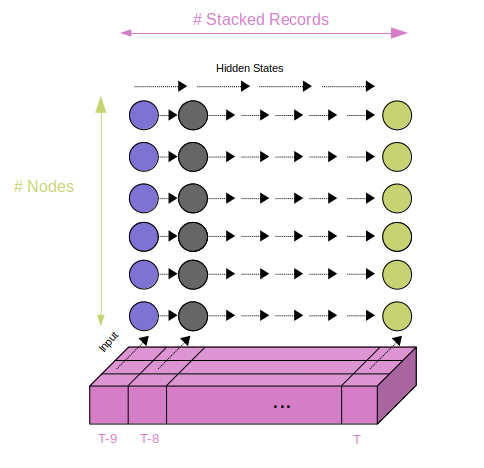



Unfolding the time dimension implies that the Recurrent Layer will 'Step' through the time dimension. It will start at the last time-step, calculate the features and hidden-state. Then it will move along, to the next step, this step had a hidden state and the input of time-step-2 as input, it will calculate the features and next hidden state and move along... and so on until it reaches the end of the time dimension.

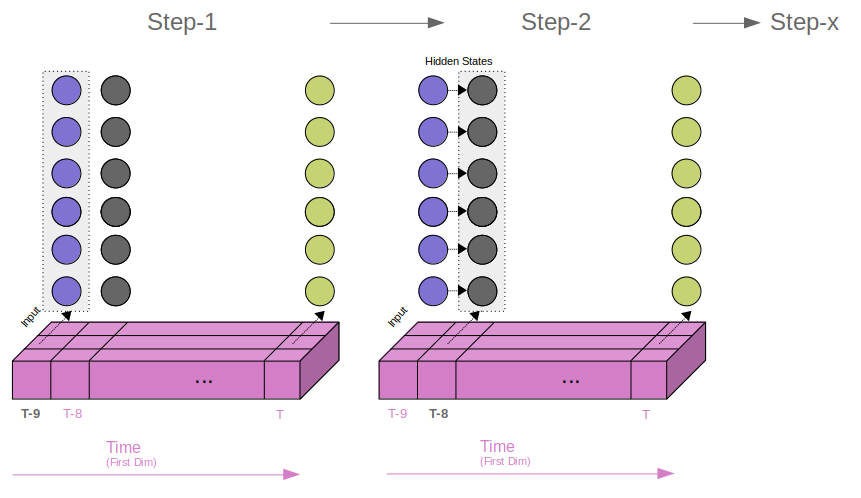


Generic RNN's suffer from vanishing (and exploding) gradients hence have a 'short term memory', they forget about the early elements in the series. `LSTM` (Long Short Term Memory) and `GRU` (Gated Recurrent Units) strive to offer solutions for this, we won't get into the detail of what exactly. They are the RNN's that are used in practice. Having said this, there probably is a limit to how many transaction can be fed to an RNN's as a series, some research on the topic might be required, but we probably want to keep this limited to 30, .. 50 or so.


## Requirements
Before running the experiment, make sure to import the `numpy`, `pandas` and `numba`, `torch`, `tqdm`, `matplotlib`, `scikit-learn`, `captum` packages in your virtual environment
```
> pip install numpy
> pip install pandas
> pip install numba
> pip install torch
> pip install tqdm
> pip install matplotlib
> pip install scikit-learn
> pip install captum
```
And that the notebook can find the `f3atur3s`, `eng1n3` and `m0d3l` packages.

In [1]:
%matplotlib inline

import gc
import datetime as dt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import f3atur3s as ft
import eng1n3.pandas as en
import m0d3l.pytorch as mp
import m0d3l.plot as mplt
import m0d3l.captum as cp

from captum.attr import IntegratedGradients

from typing import Tuple

/home/toms/Jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set a random seed for Numpy and Torch
Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
## Set up the devices, on from the data and one for modeling.
data_device  = torch.device('cpu')
model_device = torch.device('cuda') if torch.cuda.is_available() else data_device

## File Location
Change this to read from another location

In [4]:
file = '../../../../../data/bs140513_032310.csv'

## Define Features

### Define Base Features

In [5]:
# Base Features
step = ft.FeatureSource('step', ft.FEATURE_TYPE_INT_16) 
customer = ft.FeatureSource('customer', ft.FEATURE_TYPE_STRING)
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

td_base = ft.TensorDefinition('all', [step, customer, age, gender, merchant, category, amount, fraud])

### Define Derived Features
For this example we will encode everything as a one-hot feature. 

The features that change per each payment (age, gender and amount) will form a series (3 dimensional tensor). It will be **key'ed** on the merchant, the series will contain the last x payments including the specific merchant.

The features that are referential to the merchant, (merchant id and category) will be fed as a standard 2 dimensional tensor.

In [6]:
# Function that converts a step to a date. It adds the step as days to a fixed date.
def step_to_date(step_count: int):
    return dt.datetime(2020, 1, 1) + dt.timedelta(days=int(step_count))

date_time = ft.FeatureExpression('date', ft.FEATURE_TYPE_DATE_TIME, step_to_date, [step])

# Categorical Features
amount_bin   = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_8, amount, 30, scale_type='geometric')
amount_oh    = ft.FeatureOneHot('amount_oh', ft.FEATURE_TYPE_INT_8, amount_bin)
age_oh       = ft.FeatureOneHot('age_oh', ft.FEATURE_TYPE_INT_8, age)
gender_oh    = ft.FeatureOneHot('gender_oh', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh  = ft.FeatureOneHot('merchant_oh', ft.FEATURE_TYPE_INT_8, merchant)
category_oh  = ft.FeatureOneHot('category_oh', ft.FEATURE_TYPE_INT_8, category)

# Label Feature
fraud_label  = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

stacked_series = ft.FeatureSeriesStacked(
    'stacked', ft.FEATURE_TYPE_INT_8, [amount_oh, age_oh, gender_oh], 5, merchant
)

td_series      = ft.TensorDefinition('stacked', [stacked_series])
td_referential = ft.TensorDefinition('referential', [merchant_oh, category_oh])
td_label       = ft.TensorDefinition('label', [fraud_label])

# Note we 
with en.EnginePandas(num_threads=1) as e:
    ti = e.np_from_csv((td_series, td_referential, td_label), file, time_feature=date_time, inference=False)

2023-06-18 09:35:39.372 eng1n3.common.engine           INFO     Start Engine...
2023-06-18 09:35:39.372 eng1n3.pandas.pandasengine     INFO     Pandas Version : 1.5.3
2023-06-18 09:35:39.373 eng1n3.pandas.pandasengine     INFO     Numpy Version : 1.23.5
2023-06-18 09:35:39.373 eng1n3.pandas.pandasengine     INFO     Building Panda for : All_r_1 from file ../../../../../data/bs140513_032310.csv
2023-06-18 09:35:40.182 eng1n3.pandas.pandasengine     INFO     Reshaping DataFrame to: All_r_1
2023-06-18 09:35:40.226 e...ureseriesstackedprocessor  INFO     Start creating stacked series for Target Tensor Definitionstacked using 1 process(es)
2023-06-18 09:35:40.589 e...ureseriesstackedprocessor  INFO     Returning series of type int8.
2023-06-18 09:35:40.589 e...ureseriesstackedprocessor  INFO     Series Shape=[(-1, 5, 41)]


The output `ti` contains 3 numpy lists.
- The first is a (BxSxF) (Batch x Series x Features) rank 3 tensor. It contain the one-hot encoded binned amount, age and gender of the last 5 payments for this merchant.
- The second is a (BxF) (Batch x Features) rank 2 tensor. It contains the one-hot encoded merchant id and category.
- The third is a (BxF) (Batch x Features) rank 2 tensor. It contain the labels.

In [7]:
ti

TensorInstance with shapes: ((594643, 5, 41), (594643, 65), (594643, 1))

## Create Data-Sets and Loaders

In [8]:
train, val, test = ti.split_sequential(30000, 100000)

batch_size = 128
# Creating DataSets
train_ds = mp.TensorInstanceNumpyDataSet(train)
val_ds   = mp.TensorInstanceNumpyDataSet(val)
test_ds  = mp.TensorInstanceNumpyDataSet(test)

# Creating an oversampler for the training set.
train_sampler = mp.TensorInstanceNumpyLabelSampler.over_sampler(train)

# Setting up the Dataloaders.
train_dl = train_ds.data_loader(data_device, batch_size, num_workers=2, sampler=train_sampler)
val_dl   = val_ds.data_loader(data_device, batch_size, num_workers=2)
test_dl  = test_ds.data_loader(data_device, batch_size, num_workers=2)

print(train.shapes)
print(val.shapes)
print(test.shapes)

((464643, 5, 41), (464643, 65), (464643, 1))
((30000, 5, 41), (30000, 65), (30000, 1))
((100000, 5, 41), (100000, 65), (100000, 1))


### Create LSTM Model
This model is going to be a bit more complicated than the previous ones. We are going to have 2 heads as described earlier. `Head0` will be the series, `Head1` the referential data.

We will push the Head1 through an `LSTM` recurrent layer. The LSTM will return the output at each timestep, so will have shape BxSxF. Of that LSTM rank-3 tensor, we select the last output. And then concatenate the Head1 to that LSTM last output, and feed the combined flattened output through a set of linear layers.

In [9]:
class BankSimLSTM(mp.BinaryClassifier):
    def __init__(self, model_configuration: mp.ModelConfiguration):
        # Always call init, it is very important to correctly initialize the nn.Module
        super(BankSimLSTM, self).__init__(model_configuration)
        
        # Create the heads, they are the first layer of the NN.
        self.heads = self.create_heads()
        
        lstm_size = 8 
        # The first head is the Series. Create an LSTM to process it. Use Batch first to get a BxSxF output!
        self.lstm = nn.LSTM(self.heads[0].output_size, lstm_size, batch_first=True)
        
        # Set of layers
        self.layers = mp.LinLayer(
            input_size=self.heads[1].output_size+lstm_size, layer_sizes=((16,8)), dropout=0.0, bn_interval=2
        )       

        # And a tail layer. For a binary classifier this adds a linear layer to output a size of 1 + Sigmoid
        self.tail = self.create_tail(self.layers.output_size)

    # Create a forward-pass function through the neural net. Make sure to return a Tuple of Tensors!
    def forward(self, x: Tuple[torch.Tensor, ...]) -> Tuple[torch.Tensor, ...]:
        # Run heads logic
        h0 = self.heads[0](x[0])
        h1 = self.heads[1](x[1])
        # Pass head 0 (the series) through the LSTM.
        o, _ = self.lstm(h0)
        # Take the final output
        o = o[:, -1, :]
        # Concatenate to head 1.
        o = torch.cat((h1, o), dim=1)
        # Run through linear layers.
        o = self.layers(o)
        o = self.tail(o)
        return (o,)

#Create a model instance
model = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
model

BankSimLSTM(
  Number of parameters : 2977. Loss : SingleLabelBCELoss,  mean
  (heads): ModuleList(
    (0): TensorDefinitionHead(Name=SeriesTD, lc=Binary)
    (1): TensorDefinitionHead(Name=referential, lc=Binary)
  )
  (lstm): LSTM(41, 8, batch_first=True)
  (layers): LinLayer(
    (layers): Sequential(
      (lin_layer_01): Linear(in_features=73, out_features=16, bias=True)
      (lin_act_01): ReLU()
      (lin_layer_02): Linear(in_features=16, out_features=8, bias=True)
      (lin_bn_02): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (lin_act_02): ReLU()
    )
  )
  (tail): Sequential(
    (tail_lin): Linear(in_features=8, out_features=1, bias=True)
    (tail_sig): Sigmoid()
  )
)

Visually the model can be represented like so;
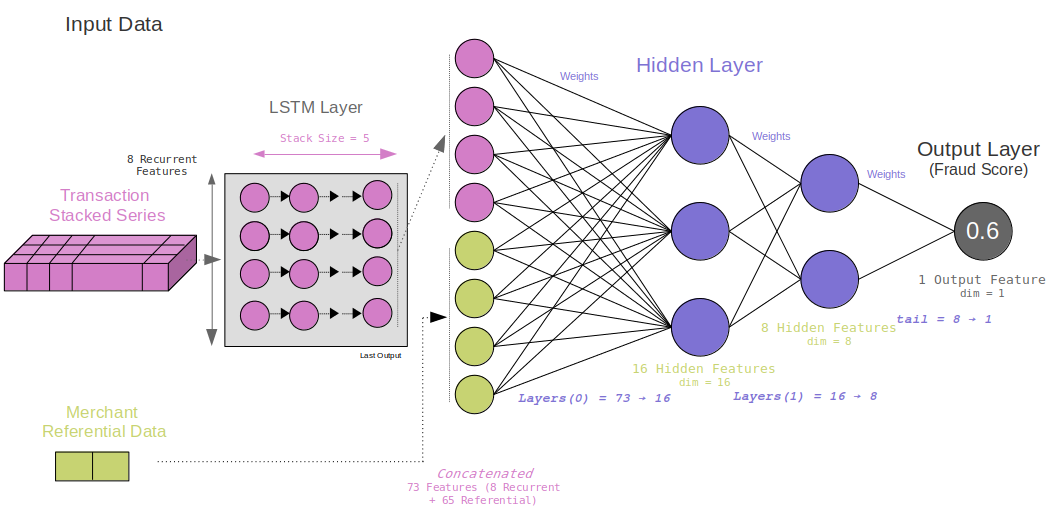

## Train

Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 332.02it/s]                                                    


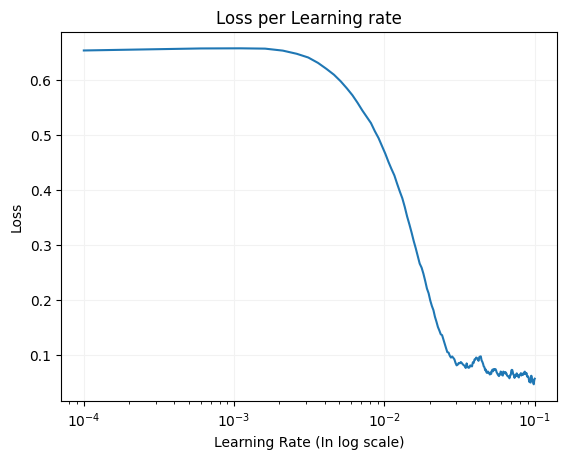

In [10]:
min_lr = 1e-4
max_lr = 1e-1
m_lr = BankSimLSTM(mp.ModelConfiguration.from_tensor_definitions(ti.target_tensor_def))
o_lr = mp.AdamWOptimizer(m_lr, lr=min_lr)
t_lr = mp.Trainer(m_lr, model_device, train_dl, val_dl)
lrs  = t_lr.find_lr(o_lr, max_lr, 200)
mplt.TrainPlot.plot_lr(lrs);
del m_lr, o_lr, t_lr, lrs
_ = gc.collect()

In [11]:
EPOCHS = 5

# First create a trainer.
trainer = mp.Trainer(model, model_device, train_dl, val_dl)
# Then an optimizer
optimizer = mp.AdamWOptimizer(model, lr=8e-3)
# Set up a OneCycle Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer.optimizer, 
            max_lr=optimizer.lr,
            steps_per_epoch=trainer.number_of_train_steps,
            epochs=EPOCHS
)

# Run the trainer for [EPOCH] epochs
history = trainer.train(EPOCHS, optimizer, scheduler)

Epoch 005/005: 100%|██████████| 3866/3866 [00:05<00:00, 653.82it/s, t_loss=0.0236, t_acc=0.994, v_loss=0.0298, v_acc=0.994]    


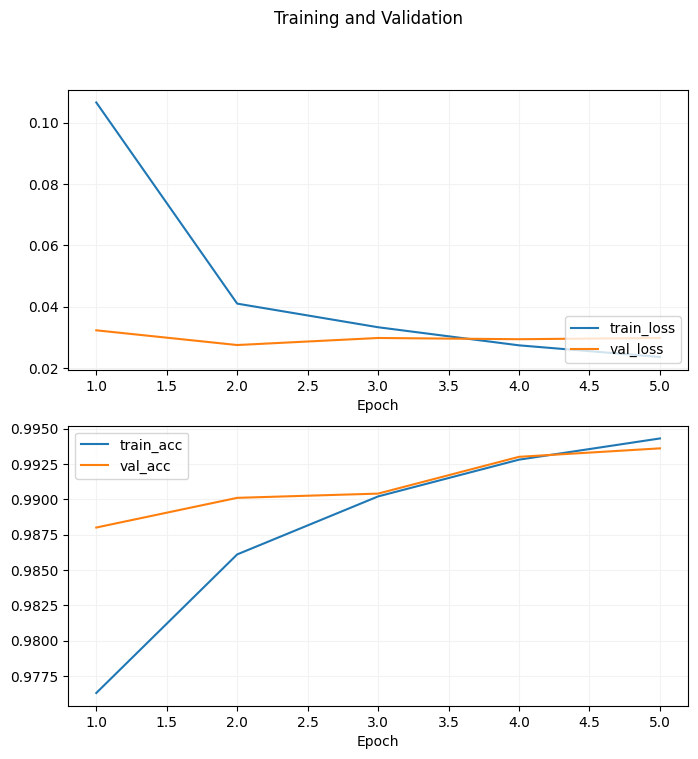

In [12]:
mplt.TrainPlot.plot_history(history, fig_size=(8,8));

## Test

During testing we can see that this model does worse on the AUC score than the 'single' record model, interestingly enough this model is worse at finding the fraud, but keeps the False positive ratio much lower.

Testing in 782 steps: 100%|█████████████████| 782/782 [00:00<00:00, 1276.50it/s]


------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     98926
         1.0       0.65      0.93      0.76      1074

    accuracy                           0.99    100000
   macro avg       0.82      0.96      0.88    100000
weighted avg       1.00      0.99      0.99    100000


auc score : 0.9751
ap score  : 0.9040
-----------------------------------------------------


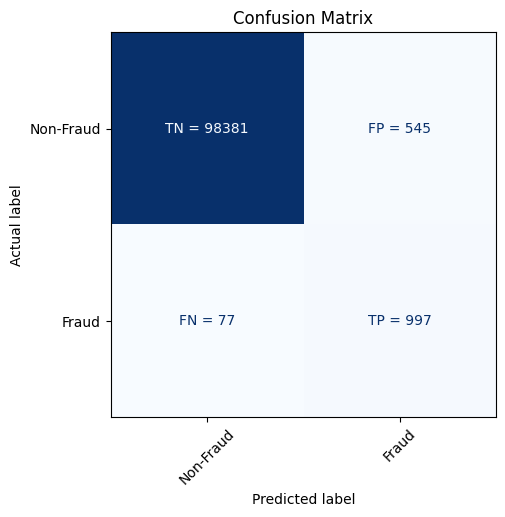

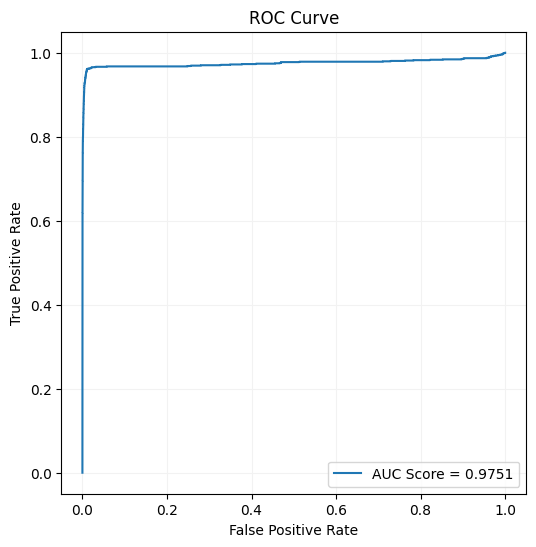

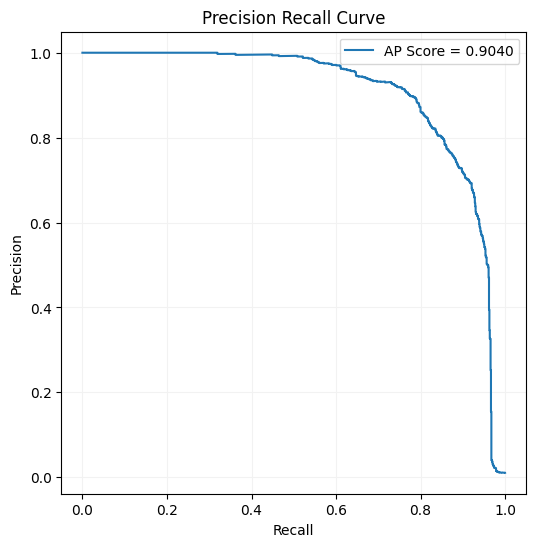

In [13]:
t = mp.Tester(model, model_device, test_dl)
results = t.test_results_binary()
mplt.TestPlot.print_binary_classification_report(results)
mplt.TestPlot.plot_binary_confusion_matrix(results, fig_size=(5,5));
mplt.TestPlot.plot_roc_curve(results, fig_size=(6,6));
mplt.TestPlot.plot_precision_recall_curve(results, fig_size=(6,6))



The AUC plot has a weird shape. It flattens out and only reaches the top on the very high scores. It seem this model makes some fairly big mistakes in the extremes. For instance there were around 70 transactions were the model thought there was less than 1% chance it would be fraud but it turned out that is was fraud. So there are False Negatives with a very low score, we could say the model got it completely wrong for those instances. (See the left spike in below diagram)

It might be interesting to compare this to other models, this is most likely a sign of over-fitting. We'll cover over-fitting more in depth later. This downturn can fairly easily be remove by using a lower learning rate and by including a bit of drop-out in the linear layers.


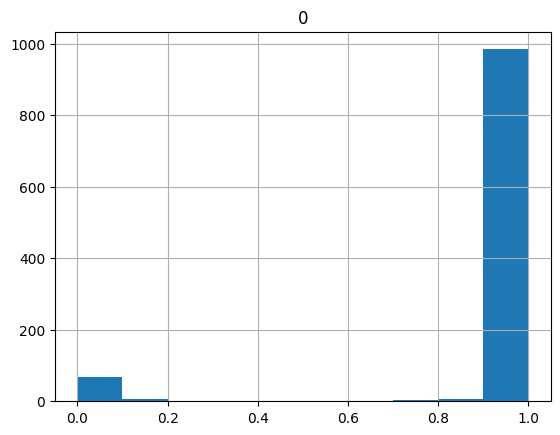

In [14]:
# This plots a histogram of scores for the actual Fraud records
p = pd.DataFrame(results.y_prd[0][results.y[0] == 1.0])
p.hist();

We can get a list of the records that are actual fraud, but got a really low score from our model. We'll leave investigating these to a future notebook.

In [15]:
np.where((results.y[0] == 1.0) & (results.y_prd[0] <= 0.1))

(array([ 4191,  7961,  7962, 11006, 11007, 11929, 11930, 13783, 13784,
        17263, 17549, 18469, 18507, 21133, 23779, 25651, 25652, 32799,
        34236, 34237, 34707, 36933, 37748, 38544, 38762, 38763, 40427,
        40428, 42386, 42387, 48538, 50779, 51273, 52048, 53092, 53093,
        53621, 53897, 55951, 59080, 60117, 63538, 70411, 70994, 72567,
        74941, 75241, 75507, 77672, 78232, 80001, 80002, 80592, 80744,
        83673, 83835, 86562, 86563, 87285, 87286, 88074, 92486, 95495,
        96009, 98967, 98968, 99382, 99525, 99526]),)

# Conclusion

This was the first model with a series as input. With this dataset it is very unclear if there are relevant sequences. This model does worse on the AUC score than a 'single record' model.

It's not really clear if this is the effect of the series. But we can observe that this model does do a better job of keeping the False Positives in check as compared to the single model versions. At the expense of the TP count unfortunately. Nevertheless, in real life it might be more desirable to have a model that is more precise rather than one that has very high recall, so something to keep in mind.

RNN's and LSTM's more specifically are one way to handle series, but there are more. Vision applications tend to use Convolutional Neural Nets `(CNN)` and since end 2019 `Transformers` have largely replaced LSTM's in the NLP domain.